In [28]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tensornetworks_pytorch.TNModels import PosMPS, Born
from tqdm.notebook import tqdm

print(torch.__version__)

1.8.0.dev20201128


Use some data

In [37]:
import pickle
for dataset in [#'biofam',
    'flare','lymphography','spect','tumor','votes']:
    with open('datasets/'+dataset, 'rb') as f:
            a=pickle.load(f)
    X=a[0].astype(int)
    print(dataset)
    print("\tdata shape:", X.shape)
    print(f"\trange of X values: {X.min()} -- {X.max()}")

def load_dataset(dataset):
    with open('datasets/'+dataset, 'rb') as f:
            a=pickle.load(f)
    X=a[0]
    X=X.astype(int)

    print("data shape:", X.shape)
    print(f"range of X values: {X.min()} -- {X.max()}")
    print(f"setting d={X.max()+1}")
    d = X.max()+1
    return X, d

flare
	data shape: (1065, 13)
	range of X values: 0 -- 7
lymphography
	data shape: (148, 19)
	range of X values: 0 -- 7
spect
	data shape: (187, 23)
	range of X values: 0 -- 1
tumor
	data shape: (339, 17)
	range of X values: 0 -- 3
votes
	data shape: (435, 17)
	range of X values: 0 -- 2


In [38]:
X,d = load_dataset('flare')

data shape: (1065, 13)
range of X values: 0 -- 7
setting d=8


In [39]:
D = 4
mps       = PosMPS(X, d, D, homogeneous=False)
mps_hom   = PosMPS(X, d, D, homogeneous=True)

rBorn     = Born(X, d, D, dtype=torch.float, homogeneous=False, log_stability=False) 
rBorn_hom = Born(X, d, D, dtype=torch.float, homogeneous=True, log_stability=False) 

cBorn     = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=False)
cBorn_hom = Born(X, d, D, dtype=torch.cfloat, homogeneous=True, log_stability=False)

rBorn_s   = Born(X, d, D, dtype=torch.float, homogeneous=False, log_stability=True) 
rBorn_s_hom = Born(X, d, D, dtype=torch.float, homogeneous=True, log_stability=True) 

cBorn_s   = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True)
cBorn_s_hom = Born(X, d, D, dtype=torch.cfloat, homogeneous=True, log_stability=True)

models     = (rBorn, cBorn, rBorn_s, cBorn_s, mps)
models_hom = (rBorn_hom, cBorn_hom, rBorn_s_hom, cBorn_s_hom, mps_hom)
for model in (*models, *models_hom):
    print(model.core.shape, "model type:", model.name)
    for p in model.parameters():
                if torch.isnan(p).any():
                    print("Model weights contain a NaN value!")

torch.Size([13, 8, 4, 4]) model type: Born (torch.float32), Non-homogeneous
torch.Size([13, 8, 4, 4]) model type: Born (torch.complex64), Non-homogeneous
torch.Size([13, 8, 4, 4]) model type: Born (torch.float32), Non-homogeneous + log_stability
torch.Size([13, 8, 4, 4]) model type: Born (torch.complex64), Non-homogeneous + log_stability
torch.Size([13, 8, 4, 4]) model type: Positive MPS, Non-homogeneous
torch.Size([8, 4, 4]) model type: Born (torch.float32), Homogeneous
torch.Size([8, 4, 4]) model type: Born (torch.complex64), Homogeneous
torch.Size([8, 4, 4]) model type: Born (torch.float32), Homogeneous + log_stability
torch.Size([8, 4, 4]) model type: Born (torch.complex64), Homogeneous + log_stability
torch.Size([8, 4, 4]) model type: Positive MPS, Homogeneous


In [40]:
import matplotlib.pyplot as plt
def train(self, dataset, batchsize, max_epochs, plot=True, **optim_kwargs):
    trainloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)
    optimizer = torch.optim.SGD(self.parameters(), **optim_kwargs)
    loss_values = [] # to plot
    print('/¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯\n')
    print(f"Training {self.name}.")
    av_batch_loss_running = -1000
    for epoch in tqdm(range(max_epochs), leave=True):
#         print("epoch", epoch)
        batch_loss = []
        for batch_idx, batch in enumerate(trainloader):
#             print(list(self.parameters()))
            for p in self.parameters():
                if torch.isnan(p).any():
                    print("Model weights contain a NaN value!")
                    if plot:
                        plt.plot(loss_values)
                        plt.show()
                    return loss_values
            self.zero_grad()
            neglogprob = 0
            for i,x in enumerate(batch):
                out = self(x)
    #             print(i, out)
                neglogprob -= out
    #             print("out",out)
            loss = neglogprob / len(batch)
    #         print("core befor\n",self.core[0][0])
    #         if batch_idx>0:
    #             print("\tgrad:",self.core.grad[0,0])
            loss.backward()
    #         print("backward.")
#             print("\tgrad:",self.core.grad[0,0])
            optimizer.step()
    #         print("optimize\n",self.core[0][0])
    #         print("\tgrad:",self.core.grad[0,0])
            with torch.no_grad():
                batch_loss.append(loss.item())
#                 n=5
#                 if batch_idx % n == 0: # print every nth batch loss
#                     print("\tbatch", batch_idx, "size", len(batch), "loss", loss.item())
        av_batch_loss = torch.Tensor(batch_loss).mean().item()
#         print(f"ep{epoch} av_batch_loss\t {av_batch_loss}")
        loss_values.append(av_batch_loss)
        if abs(av_batch_loss_running - av_batch_loss) < .0001:
            print("Early stopping")
            break
        av_batch_loss_running = av_batch_loss
    print("loss_values", loss_values)
    if plot:
        plt.plot(loss_values)
        plt.show()
    print('\_____Finished_training_____\n')
    return loss_values

# train(rBorn, X, batchsize=30, max_epochs = 10, lr=0.1)

/¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

Training Born (torch.float32), Homogeneous.


Early stopping

loss_values [16.586997985839844, 18.471174240112305, 17.35706329345703, 17.527795791625977, 16.925804138183594, 16.45563507080078, 16.130918502807617, 15.890591621398926, 15.656882286071777, 15.46841812133789, 15.365814208984375, 15.242705345153809, 15.139239311218262, 15.03407096862793, 14.93923282623291, 14.871479988098145, 14.76778507232666, 14.660947799682617, 14.608816146850586, 14.527117729187012, 14.474759101867676, 14.422759056091309, 14.338093757629395, 14.30745792388916, 14.261396408081055, 14.156336784362793, 14.10807991027832, 14.055614471435547, 13.981101036071777, 13.936293601989746, 13.88025188446045, 13.832051277160645, 13.778742790222168, 13.733819007873535, 13.679069519042969, 13.643928527832031, 13.585305213928223, 13.54343318939209, 13.540375709533691, 13.453676223754883, 13.429557800292969, 13.382503509521484, 13.34640121459961, 13.27448558807373, 13.22534465789795, 13.173969268798828, 13.119202613830566, 13.097981452941895, 13.067948341369629, 13.0

Model weights contain a NaN value!

/¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

Training Born (torch.float32), Homogeneous + log_stability.



loss_values [21.538331985473633, 14.241035461425781, 12.918619155883789, 12.316905975341797, 11.957286834716797, 12.247958183288574, 11.550705909729004, 11.336464881896973, 11.27908992767334, 11.067258834838867, 11.047209739685059, 11.27095890045166, 11.96870231628418, 11.332929611206055, 17.660310745239258, 16.20631217956543, 15.232294082641602, 14.703307151794434, 14.528043746948242, 14.068563461303711, 13.655665397644043, 13.303954124450684, 13.09980583190918, 13.27575397491455, 13.087194442749023, 13.24566650390625, 13.092564582824707, 12.897894859313965, 13.051695823669434, 12.820874214172363, 12.576937675476074, 12.408092498779297, 12.484344482421875, 12.581014633178711, 12.433671951293945, 12.29894733428955, 12.043755531311035, 11.964072227478027, 11.887948989868164, 11.744363784790039, 11.651985168457031, 11.616632461547852, 11.52914047241211, 11.482612609863281, 11.433852195739746, 11.360981941223145, 11.335305213928223, 11.297754287719727, 11.260625839233398, 11.224459648132

Model weights contain a NaN value!

/¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

Training Positive MPS, Homogeneous.


Model weights contain a NaN value!



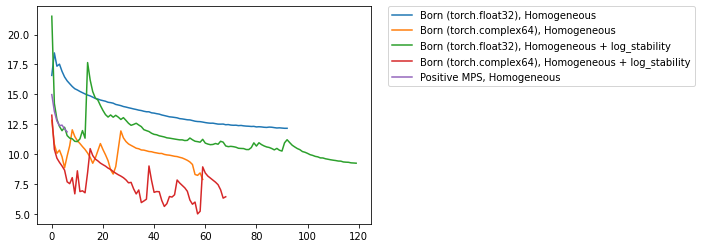

In [41]:
model_loss_values={}
for model in models_hom:
    loss_values = train(model, X, batchsize=35, plot=False, max_epochs = 120, lr=0.02)
    plt.plot(loss_values, label=model.name)
    model_loss_values["model.name"]=loss_values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

/¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

Training Born (torch.float32), Non-homogeneous.



loss_values [18.41334342956543, 15.697354316711426, 12.423572540283203, 11.88095474243164, 10.003332138061523, 9.46167278289795, 11.448525428771973, 10.668424606323242, 10.050966262817383, 13.044195175170898, 12.016237258911133, 11.320198059082031, 10.906416893005371, 10.509834289550781, 10.307424545288086, 9.884716987609863, 9.475747108459473, 9.120818138122559, 8.75476360321045, 8.431882858276367, 8.176566123962402, 7.920973777770996, 7.8268232345581055, 7.593903064727783, 7.540970802307129, 7.435048580169678, 7.417405128479004, 7.925734996795654, 7.970584392547607, 7.610926628112793, 7.316051959991455, 7.268495082855225, 7.231170654296875, 7.209517002105713, 7.191112995147705, 7.1782450675964355, 7.160427093505859, 7.219094276428223, 7.205583572387695, 7.154006481170654, 7.1096110343933105, 7.153435707092285, 7.276581764221191, 7.103175640106201, 7.103743553161621, 8.200246810913086, 7.196761608123779, 7.088575839996338, 7.076168537139893, 7.058196544647217, 7.045327186584473, 7.06


loss_values [8.491390228271484, 7.743829727172852, 7.2687811851501465, 7.062438011169434, 7.063661575317383, 6.714871883392334, 6.634990215301514, 6.574898719787598, 6.490335941314697, 6.451807975769043, 6.414282321929932, 6.395496368408203, 6.338381767272949, 6.305484294891357, 6.2753167152404785, 6.255862236022949, 6.199887275695801, 6.144956111907959, 6.071486949920654, 5.9645466804504395, 5.812228679656982, 5.4983367919921875, 4.682357311248779, 4.503656387329102, 5.644001483917236, 6.341782093048096, 5.8281073570251465, 4.9434895515441895, 5.144148826599121, 3.934290647506714, 3.929348945617676, 4.3094401359558105, 5.525941848754883, 5.167633056640625, 4.136703968048096, 4.049666404724121, 3.6730761528015137, 5.621821403503418, 5.520069599151611, 5.358335494995117, 5.164977073669434, 4.737991809844971, 3.7743542194366455, 5.110261917114258, 4.195228099822998, 6.756697177886963, 6.246860027313232, 6.134204387664795, 6.042236328125, 5.986785888671875, 5.953530788421631, 5.941903114


loss_values [12.634193420410156, 9.35047435760498, 7.348610877990723, 5.865190505981445, 5.584023475646973, 5.800696849822998, 5.430023670196533, 9.1017427444458, 8.02895736694336, 6.298472881317139, 5.661681175231934, 10.207793235778809, 10.683419227600098, 10.98167610168457, 9.126374244689941, 11.151908874511719, 11.167789459228516, 9.904462814331055, 8.67209529876709, 7.518465518951416, 6.73984956741333, 6.273116111755371, 5.9862213134765625, 5.897968769073486, 5.683940410614014, 5.519092082977295, 5.406789779663086, 5.2937092781066895, 5.223711967468262, 5.149569988250732, 5.115121841430664, 5.052052974700928, 4.9648118019104, 4.947447299957275, 4.885218143463135, 4.860198020935059, 4.830240726470947, 4.814044952392578, 4.752038478851318, 4.730818748474121, 4.735666751861572, 4.694427490234375, 4.675293922424316, 4.658956527709961, 4.615362167358398, 4.586314678192139, 4.570427894592285, 4.578689098358154, 4.547006130218506, 4.53505802154541, 4.522000789642334, 4.499585151672363, 


loss_values [6.724488258361816, 6.52506685256958, 5.318921089172363, 5.737081050872803, 4.260114669799805, 4.206964492797852, 3.8405563831329346, 3.6406378746032715, 5.10014009475708, 5.320913791656494, 5.012693405151367, 4.850839614868164, 4.77580451965332, 4.664849281311035, 4.591048240661621, 4.500394821166992, 4.4559431076049805, 4.407907962799072, 4.321036338806152, 4.257960796356201, 4.222997665405273, 4.18100643157959, 4.089008331298828, 4.026768684387207, 3.982489824295044, 3.9360501766204834, 3.873107433319092, 3.8298604488372803, 3.7596585750579834, 3.7120800018310547, 3.654812812805176, 3.579745054244995, 3.475172996520996, 3.385570764541626, 3.2224338054656982, 2.840998649597168, 3.8788955211639404, 3.1652019023895264, 3.5664238929748535, 2.9387989044189453, 5.119013786315918, 4.961657524108887, 4.380815029144287, 3.7274341583251953, 2.543057441711426, 2.5782470703125, 3.919404983520508, 2.689208507537842, 3.281179666519165, 1.5375386476516724, 2.3061912059783936, 4.058021


loss_values [9.891922950744629, 7.006329536437988, 6.7545695304870605, 6.682060718536377, 6.631499290466309, 6.607896327972412, 6.597376346588135, 6.575427055358887, 6.5955023765563965, 6.580860137939453, 6.598390579223633, 6.5547919273376465, 6.566196441650391, 6.559140682220459, 6.560823917388916, 6.558175086975098, 6.562982559204102, 6.590170383453369, 6.599185943603516, 6.547458648681641, 6.582982063293457, 6.5688018798828125, 6.569426536560059, 6.546279430389404, 6.56453275680542, 6.5775532722473145, 6.550439834594727, 6.509257793426514, 6.516150951385498, 6.5574164390563965, 6.541494846343994, 6.514647960662842, 6.512362003326416, 6.529063701629639, 6.532475471496582, 6.554434299468994, 6.563388824462891, 6.532426357269287, 6.507051944732666, 6.524789333343506, 6.550511837005615, 6.524174690246582, 6.528439044952393, 6.5104193687438965, 6.513401985168457, 6.538661479949951, 6.522949695587158, 6.506211280822754, 6.528298377990723, 6.537562370300293, 6.5244879722595215, 6.51804685

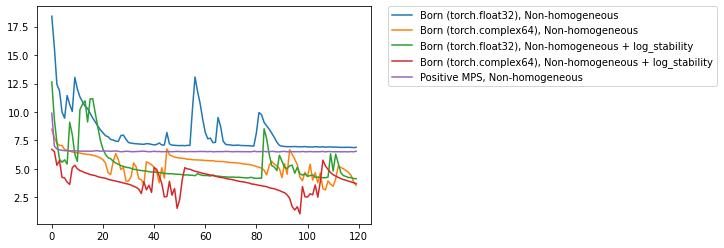

In [42]:
model_loss_values={}
for model in models:
    loss_values = train(model, X, batchsize=35, plot=False, max_epochs = 120, lr=0.02)
    plt.plot(loss_values, label=model.name)
    model_loss_values["model.name"]=loss_values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [57]:
# testing complex functions
real = torch.tensor([[1, 2],[2, 1]], dtype=torch.float32)
imag = torch.tensor([[3, 4],[1, 2]], dtype=torch.float32)
z = torch.complex(real, imag)
# z = torch.randn(2,2, dtype=torch.cfloat)
z.requires_grad=True
b = (2.7j*z + 3.4*z + 18)
L = torch.einsum('ij,ji,ij,ji->',b,b,b,b).abs()
L.backward()

print("z:\n",z,'\n', sep='')
print("loss grad_fn:\n", L.grad_fn,'\n', sep='')
print("z.grad:\n", z.grad,'\n', sep='')

def infnorm(tensor):
#     return torch.max(torch.sum(abs(tensor), dim=-1))
    print(tensor.abs().max())
    return torch.linalg.norm(tensor, ord=float('inf')).real

norm = infnorm
print(norm(z.grad))
print(norm(z.grad[0]))

z:
tensor([[1.+3.j, 2.+4.j],
        [2.+1.j, 1.+2.j]], requires_grad=True)

loss grad_fn:

z.grad:
tensor([[103476.6328-38667.7930j, 224180.9375+59425.4219j],
        [219980.8125-67495.4922j, 105286.0781+37877.9062j]])

tensor(231923.4219)
tensor(342388.8438)
tensor(231923.4219)
tensor(231923.4219)


In [20]:
print(matnorm(z))
print(torch.max(torch.sum(abs(z), dim=1)))

tensor(7.6344+0.j, grad_fn=<CopyBackwards>)
tensor(7.6344, grad_fn=<MaxBackward1>)
